In [1]:
import  glob
import  os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import  librosa
import  librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from scipy import signal


%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.utils.np_utils import to_categorical
from keras.layers import Input, LSTM, GRU, Dense
from keras.layers import Bidirectional

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU


Using TensorFlow backend.


In [3]:
ROOT_DIRECTORY = 'dataset/'

declarative_CLASS_train = 'NLP_Declarative/NLP_train_16k/*.wav'
question_CLASS_train = 'NLP_Question/NLP_train_16k/*.wav'

declarative_CLASS_test = 'NLP_Declarative/NLP_test_16k/*.wav'
question_CLASS_test = 'NLP_Question/NLP_test_16k/*.wav'


declarative_CLASS_val = 'NLP_Declarative/NLP_val_16k/*.wav'
question_CLASS_val = 'NLP_Question/NLP_val_16k/*.wav'


train_percentile = 0.8
test_percentile = 0.2

In [4]:
def filenames_list(directory_path):
#     For running in whole dataset
#     return [filename for filename in glob.glob(directory_path) ]
    return [filename for filename in glob.glob(directory_path) if np.random.uniform(0,1)>=0.9]

In [5]:
dec_files_list_train=filenames_list(ROOT_DIRECTORY+declarative_CLASS_train)
ques_files_list_train=filenames_list(ROOT_DIRECTORY+question_CLASS_train)

print('len(dec_files_list_train):',len(dec_files_list_train))
print('len(ques_files_list_train):',len(ques_files_list_train))

len(dec_files_list_train): 1292
len(ques_files_list_train): 1125


In [6]:
dec_files_list_test=filenames_list(ROOT_DIRECTORY+declarative_CLASS_test)
ques_files_list_test=filenames_list(ROOT_DIRECTORY+question_CLASS_test)

print('len(dec_files_list_test):',len(dec_files_list_test))
print('len(ques_files_list_test):',len(ques_files_list_train))

len(dec_files_list_test): 280
len(ques_files_list_test): 1125


In [7]:
dec_files_list_val=filenames_list(ROOT_DIRECTORY+declarative_CLASS_val)
ques_files_list_val=filenames_list(ROOT_DIRECTORY+question_CLASS_val)

print('len(dec_files_list_val):',len(dec_files_list_val))
print('len(ques_files_list_val):',len(ques_files_list_val))

len(dec_files_list_val): 68
len(ques_files_list_val): 76


In [ ]:
# print(len(dec_files_list_train), len(dec_files_list_test), len(dec_files_list_val))
# print(len(ques_files_list_train), len(ques_files_list_test), len(ques_files_list_val))

In [65]:
def extract_mfcc(file_name):
    X, sample_rate = librosa.load(file_name)
#     print ("Features :",len(X), X.shape, "sampled at ", sample_rate, "hz")
#     stft = np.abs(librosa.stft(X))
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mel_spect = librosa.feature.melspectrogram(y=X, sr=sample_rate,n_mels=128,fmax=8000)
    
    window_size=10
    step_size=5
    eps=1e-10
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    _,_,spect = signal.spectrogram(X, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap,detrend=False)
    
#     chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#     mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,mel_spect,np.log(spect.T.astype(np.float32) + eps).T

In [105]:
Max_RNN=500


In [106]:
def parse_audio_files(filename_list, label, Max_RNN):
    FEATURE = 'MFCC'
    
    max_len=-999999
    Xs_train=[]
    Xs_test=[]
#     probability = [float(v) for v in percentiles.values()]
    
#     features, labels = np.empty((0,193)), np.empty(0)

    for e,fn in enumerate(filename_list):
        mfccs,mel_spect,spect = extract_mfcc(fn)
        
        if FEATURE == 'SPECT':
            _,_,mfccs = extract_mfcc(fn)
#             print(mfccs.shape)

            if len(mfccs[0])> max_len:
                max_len=len(mfccs[0])

            mfccs=np.pad(mfccs, [(0, 0), (0, Max_RNN-len(mfccs[0]))], mode='constant')
            Xs_train.append(mfccs)
            
        elif FEATURE == 'MFCC':
            mfccs,_,_ = extract_mfcc(fn)
#             print(mfccs.shape)

            if len(mfccs[0])> max_len:
                max_len=len(mfccs[0])

            mfccs=np.pad(mfccs, [(0, 0), (0, Max_RNN-len(mfccs[0]))], mode='constant')
            Xs_train.append(mfccs.T)
        
#         portion =  np.random.choice(2, 1, p=probability)
#         if portion == 0:
#             Xs_train.append(mfccs.T)
#         elif portion == 1:
#             Xs_test.append(mfccs.T)
            
#         print(mfccs.shape)
#         Xs_train.append(mfccs.T)
    #### Label for training
    if label == 'declarative':
        Ys_train = to_categorical(np.ones(len(Xs_train)),2)
#         Ys_test = to_categorical(np.ones(len(Xs_test)),2)
        
    elif label == 'question':
        Ys_train = to_categorical(np.zeros(len(Xs_train)),2)
#         Ys_test = to_categorical(np.zeros(len(Xs_test)),2)
    
    Xs_train = np.array(Xs_train)
#     Xs_test = np.array(Xs_test)
    return Xs_train, Ys_train, max_len 
        
#     for label, sub_dir in enumerate(sub_dirs):
#         for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
#             try:
#                 mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
#                 ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
#                 features = np.vstack([features,ext_features])
#                 labels = np.append(labels, fn.split('fold')[1].split('-')[1])
#             except:
#                 print("Error processing " + fn + " - skipping")
#     return np.array(features), np.array(labels, dtype = np.int)

### Creating mfcc vectors for declarative and questions

In [107]:
dec_Xs_train, dec_Ys_train, dec_max_len=parse_audio_files(dec_files_list_train, "declarative", Max_RNN)
print(dec_Xs_train.shape, dec_Ys_train.shape)

(1283, 111, 2500) (1283, 2)


In [108]:
dec_Xs_test, dec_Ys_test, dec_max_len_test=parse_audio_files(dec_files_list_test, "declarative", Max_RNN)
dec_Xs_val, dec_Ys_val, dec_max_len_val=parse_audio_files(dec_files_list_val, "declarative", Max_RNN)

In [109]:
print(dec_Xs_test.shape, dec_Ys_test.shape)
print(dec_Xs_val.shape, dec_Ys_val.shape)

(278, 111, 2500) (278, 2)
(61, 111, 2500) (61, 2)


In [110]:
ques_Xs_train, ques_Ys_train, ques_max_len_train=parse_audio_files(ques_files_list_train, "question", Max_RNN)

In [111]:
ques_Xs_test, ques_Ys_test, ques_max_len_test=parse_audio_files(ques_files_list_test, "question", Max_RNN)
ques_Xs_val, ques_Ys_val, ques_max_len_val=parse_audio_files(ques_files_list_val, "question", Max_RNN)

In [ ]:
# percentiles = {'train':train_percentile, 'test':test_percentile}
# dec_Xs_train, dec_Xs_test, dec_Ys_train, dec_Ys_test, dec_max_len=parse_audio_files(percentiles, dec_files_list, "declarative", Max_RNN)

# print(len(dec_Xs_train), len(dec_Ys_train), len(dec_Xs_test), len(dec_Ys_test), "Max Len: ", dec_max_len)

### Write data into files

In [112]:
def write_file(file_name, vector_name):
    ### Writing training data S

    with open(file_name, 'wb') as fs:
        for val in vector_name:
#             print(val)
#             sn, sr=librosa.load(fname_list[i], sr=None)
#             Sn=librosa.stft(sn, n_fft=1024, hop_length=512)
# #             mag_Sn=np.abs(Sn)
#     #         trn_arr=np.concatenate((trn_arr, mag_Sn), axis=1)
            np.savetxt(fs, val, fmt='%.5f')
            fs.write(b'\n')
    fs.close()            



### Write data for MFCC

Run this or other one.

In [113]:
write_file("dec_Xs_val_full_mfcc.txt", dec_Xs_val)
write_file("ques_Xs_val_full_mfcc.txt", ques_Xs_val)

In [114]:
write_file("dec_Xs_test_full_mfcc.txt", dec_Xs_test)
write_file("ques_Xs_test_full_mfcc.txt", ques_Xs_test)

In [ ]:
write_file("dec_Xs_train_full_mfcc.txt", dec_Xs_train)
write_file("ques_Xs_train_full_mfcc.txt", ques_Xs_train)

### Write data for Spectogram

Run this or other one.

In [ ]:
write_file("dec_Xs_val_full_spec.txt", dec_Xs_val)
write_file("ques_Xs_val_full_spec.txt", ques_Xs_val)

In [ ]:
write_file("dec_Xs_test_full_spec.txt", dec_Xs_test)
write_file("ques_Xs_test_full_spec.txt", ques_Xs_test)

In [116]:
write_file("dec_Xs_train_full_spec.txt", dec_Xs_train)
write_file("ques_Xs_train_full_spec.txt", ques_Xs_train)

### Read data from files

In [117]:
### Function for Reading file

def read_file(file_name):
    with open(file_name) as f:
        lines=f.readlines()
        print(len(lines))
        sentence_full=[]
        count = 0
        sentence=[]
        for line in lines:

            if count < Max_RNN:
                if count ==0:
                    sentence=np.array(np.fromstring(line, dtype=float, sep=' '), ndmin=2)
                    count+=1
                else:
                    myarray = np.array(np.fromstring(line, dtype=float, sep=' '), ndmin=2)
                    sentence=np.concatenate((sentence, myarray), axis=0)
                    count+=1
            else:
                sentence_full.append(sentence) 
                count=0
                sentence=[]
        return sentence_full


### Read MFCC data from file

Run this one or other.

In [118]:
dec_Xs_val_file = read_file("dec_Xs_val_full_mfcc.txt")
ques_Xs_val_file = read_file("ques_Xs_val_full_mfcc.txt")

6832


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
print(len(dec_Xs_val_file), dec_Xs_val_file[0].shape)
print(len(ques_Xs_val_file), ques_Xs_val_file[0].shape)

In [9]:
dec_Xs_test_file = read_file("dec_Xs_test_full_mfcc.txt")
ques_Xs_test_file = read_file("ques_Xs_test_full_mfcc.txt")


134268
145791


In [ ]:
dec_Xs_train_file = read_file("dec_Xs_train_full_mfcc.txt")
ques_Xs_train_file = read_file("ques_Xs_train_full_mfcc.txt")

### Read Spectogram data from file

Run this or other.

In [ ]:
dec_Xs_val_file = read_file("dec_Xs_val_full_spec.txt")
ques_Xs_val_file = read_file("ques_Xs_val_full_spec.txt")

In [ ]:
print(len(dec_Xs_val_file), dec_Xs_val_file[0].shape)
print(len(ques_Xs_val_file), ques_Xs_val_file[0].shape)

In [ ]:
dec_Xs_test_file = read_file("dec_Xs_test_full_spec.txt")
ques_Xs_test_file = read_file("ques_Xs_test_full_spec.txt")

In [11]:
dec_Xs_train_file = read_file("dec_Xs_train_full_spec.txt")
ques_Xs_train_file = read_file("ques_Xs_train_full_spec.txt")

578655


### Create Label data for 2 classes

In [12]:
dec_Ys_train_file = to_categorical(np.ones(len(dec_Xs_train_file)),2)
dec_Ys_test_file = to_categorical(np.ones(len(dec_Xs_test_file)),2)
dec_Ys_val_file = to_categorical(np.ones(len(dec_Xs_val_file)),2)

In [13]:
ques_Ys_train_file = to_categorical(np.zeros(len(ques_Xs_train_file)),2)
ques_Ys_test_file = to_categorical(np.zeros(len(ques_Xs_test_file)),2)
ques_Ys_val_file = to_categorical(np.zeros(len(ques_Xs_val_file)),2)

In [14]:
print(dec_Xs_val_file[0].shape)
len(dec_Xs_val_file)

(500, 40)


55

In [15]:
bx = np.concatenate( (dec_Xs_train_file,ques_Xs_train_file), axis = 0)
by = np.concatenate( (dec_Ys_train_file,ques_Ys_train_file), axis = 0)
print('bx',bx.shape, 'by', by.shape)

bx (2467, 500, 40) by (2467, 2)


In [16]:
bx_val = np.concatenate( (dec_Xs_val_file,ques_Xs_val_file), axis = 0)
by_val = np.concatenate( (dec_Ys_val_file,ques_Ys_val_file), axis = 0)
print('bx_val',bx_val.shape, 'by_val', by_val.shape)

bx_val (124, 500, 40) by_val (124, 2)


In [17]:
n = bx.shape[0]
suffle_n = np.random.permutation(n)

bx = bx[suffle_n]
by = by[suffle_n]

In [18]:
n = bx_val.shape[0]
suffle_n = np.random.permutation(n)

bx_val = bx_val[suffle_n]
by_val = by_val[suffle_n]

In [19]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
set_session(tf.Session(config=config))

### Model

In [20]:
height, width, depth = Max_RNN, 40, 1 # MNIST images are 28x28 and greyscale
num_classes = 2 # there are 10 classes (1 per digit)


batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout

conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer

drop_prob_1 = 0.25 # dropout after pooling with probability 0.25

hidden_size = 512 # the FC layer will have 512 neurons

In [21]:
bx=bx[:,:,:,np.newaxis]
print('bx',bx.shape, 'by', by.shape)

bx_val=bx_val[:,:,:,np.newaxis]

bx (2467, 500, 40, 1) by (2467, 2)


In [22]:
# Max_RNN = 1500

# create the model

inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)

# Input block
# x = ZeroPadding2D(padding=(2, 2))(inp)
x = BatchNormalization(axis=2, name='bn_0_freq')(inp)

# Conv block 1
x = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', name='conv1')(x)
x = BatchNormalization(axis=1, name='bn1')(x)
# x = ELU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
x = Dropout(0.1, name='dropout1')(x)


# Conv block 2
x = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', name='conv2')(x)
x = BatchNormalization(axis=1,  name='bn2')(x)
# x = ELU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
x = Dropout(0.1, name='dropout2')(x)

# Conv block 3
x = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', name='conv3')(x)
x = BatchNormalization(axis=1, name='bn3')(x)
# x = ELU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
x = Dropout(0.1, name='dropout3')(x)

# Conv block 4
x = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', name='conv4')(x)
x = BatchNormalization(axis=1,  name='bn4')(x)
# x = ELU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool4')(x)
x = Dropout(0.1, name='dropout4')(x)
    
print (x.shape)

# reshaping
x = Reshape((-1, 32))(x)
print (x.shape)

# GRU block 1, 2, output
x = Bidirectional(GRU(100, return_sequences=False, name='gru1'), name='bd1')(x)
x = Dropout(0.3)(x)

x = Dense(2, activation='sigmoid', name='output')(x)

model = Model(inp,x)
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

print(model.summary())

(?, 31, 2, 32)
(?, ?, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 40, 1)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 500, 40, 1)        160       
_________________________________________________________________
conv1 (Conv2D)               (None, 500, 40, 32)       320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 500, 40, 32)       2000      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 250, 20, 32)       0         
_________________________________________________________________
dropout1 (Dropout)           (None, 250, 20, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 250, 20, 64)  

In [26]:
history = model.fit(bx, by, validation_data = (bx_val, by_val), shuffle=True, nb_epoch=20, batch_size=64)

Train on 2467 samples, validate on 124 samples
Epoch 1/20
  64/2467 [..............................] - ETA: 6s - loss: 0.0054 - acc: 1.0000

/N/u/knayem/.conda/envs/b659/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


2467/2467 [==============================] - 6s 3ms/step - loss: 0.0131 - acc: 0.9951 - val_loss: 0.1295 - val_acc: 0.9677
Epoch 2/20
2467/2467 [==============================] - 6s 3ms/step - loss: 0.0123 - acc: 0.9964 - val_loss: 0.0459 - val_acc: 0.9677
Epoch 3/20
2467/2467 [==============================] - 6s 2ms/step - loss: 0.0061 - acc: 0.9976 - val_loss: 0.0520 - val_acc: 0.9919
Epoch 4/20
2467/2467 [==============================] - 6s 2ms/step - loss: 0.0159 - acc: 0.9951 - val_loss: 0.0607 - val_acc: 0.9677
Epoch 5/20
2467/2467 [==============================] - 6s 3ms/step - loss: 0.0116 - acc: 0.9968 - val_loss: 0.0320 - val_acc: 0.9839
Epoch 6/20
2467/2467 [==============================] - 6s 3ms/step - loss: 0.0058 - acc: 0.9976 - val_loss: 0.1096 - val_acc: 0.9435
Epoch 7/20
2467/2467 [==============================] - 6s 3ms/step - loss: 0.0065 - acc: 0.9980 - val_loss: 0.0314 - val_acc: 0.9839
Epoch 8/20
2467/2467 [==============================] - 6s 2ms/step - los

In [27]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


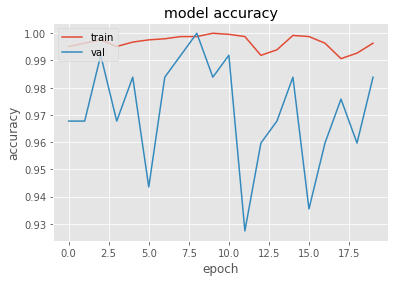

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

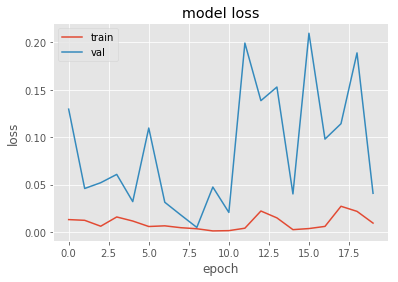

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
bx_test = np.concatenate( (dec_Xs_test_file, ques_Xs_test_file), axis = 0)
by_test = np.concatenate( (dec_Ys_test_file, ques_Ys_test_file), axis = 0)

bx_test=bx_test[:,:,:,np.newaxis]

scores = model.evaluate(bx_test, by_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.96%
